# 📈 QuickBooks Sales Forecasting: Future Prediction

## Overview
This notebook demonstrates how to use our trained machine learning model to generate future sales predictions for different product categories. We'll walk through the entire prediction pipeline:

1. **Data Preparation**: Loading historical data and setting up forecast parameters
2. **Feature Engineering**: Generating model-ready features for future dates
3. **Model Inference**: Using our trained model to predict future sales
4. **Visualization & Analysis**: Examining prediction results and trends
5. **Forecast Evaluation**: Assessing the quality of our predictions

These forecasts can help businesses make data-driven decisions about inventory management, staffing, and financial planning.


In [1]:
# Import required libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
import logging

# Import custom modules
from src.feature_engineering.feature_builder import FeatureBuilder
from src.db_operations import get_historical_sales, store_predictions

# Set plot style for professional visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## 1. Load Model and Historical Data

First, we load our trained model and the required feature columns. The model was trained in the previous notebook (`03_model_training.ipynb`) and saved to disk. We also load historical sales data to use as a baseline for our predictions.


In [2]:
# Define paths
MODEL_PATH = '../model/model.pkl'
FEATURE_COLUMNS_PATH = '../model/feature_columns.pkl'
HISTORICAL_DATA_PATH = '../data/processed/sales_engineered_features.csv'

# Load trained model
try:
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
    print(f"Successfully loaded model from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Load required feature columns
try:
    with open(FEATURE_COLUMNS_PATH, 'rb') as f:
        feature_columns = pickle.load(f)
    print(f"Successfully loaded {len(feature_columns)} feature columns")
except Exception as e:
    print(f"Error loading feature columns: {e}")
    raise

# Load historical data
try:
    full_data = pd.read_csv(HISTORICAL_DATA_PATH, parse_dates=['date'], index_col='date')
    full_data = full_data.sort_index()
    print(f"Loaded historical data with {len(full_data)} rows from {full_data.index.min()} to {full_data.index.max()}")
except Exception as e:
    print(f"Error loading historical data: {e}")
    raise

# Display information about the historical data
print(f"Historical data shape: {full_data.shape}")
print(f"Date range: {full_data.index.min()} to {full_data.index.max()}")
print(f"Categories: {', '.join([col for col in full_data.columns if col in ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']])}")

# Display sample of historical data
full_data[['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']].tail()

Successfully loaded model from ../model/model.pkl
Successfully loaded 33 feature columns
Loaded historical data with 1812 rows from 2020-05-22 00:00:00 to 2025-05-07 00:00:00
Historical data shape: (1812, 45)
Date range: 2020-05-22 00:00:00 to 2025-05-07 00:00:00
Categories: Beauty, Books, Clothing, Electronics, Furniture, Groceries, Sports, Toys


,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys
date,,,,,,,,
2025-05-03,4466.09,3414.43,5482.39,1676.84,1219.80,2274.59,2656.71,2721.31
2025-05-04,4013.67,2921.58,6091.02,1890.71,2420.20,2194.25,2552.81,2695.07
2025-05-05,4132.51,2490.60,5136.57,1204.61,1437.99,2164.47,2645.81,2569.67
2025-05-06,4101.22,2500.62,4470.40,2570.00,1646.31,1949.27,2767.66,2274.70
2025-05-07,4550.94,2798.59,4624.40,1557.07,2710.36,2312.89,2383.78,2271.58


## 2. Configure Forecast Parameters

We need to define the time period for which we want to generate predictions. We'll start from the day after our last historical data point and forecast for a specified number of days into the future.


In [3]:
# Define forecast parameters
FORECAST_DAYS = 30  # Number of days to forecast

# Determine start and end dates for forecasting
forecast_start_date = full_data.index.max() + timedelta(days=1)
forecast_end_date = forecast_start_date + timedelta(days=FORECAST_DAYS-1)

print(f"Forecast period: {forecast_start_date.strftime('%Y-%m-%d')} to {forecast_end_date.strftime('%Y-%m-%d')} ({FORECAST_DAYS} days)")

Forecast period: 2025-05-08 to 2025-06-06 (30 days)


## 3. Generate Features for Future Dates

Now we'll use our `FeatureBuilder` class to generate the features needed for prediction. This class handles all the complex feature engineering, including creating lag features and date-based features.


In [4]:
# Initialize the FeatureBuilder
builder = FeatureBuilder()

# Generate future features
print(f"Generating features for {forecast_start_date} to {forecast_end_date}")
future_features = builder.get_model_features(
    start_date=forecast_start_date.strftime('%Y-%m-%d'),
    end_date=forecast_end_date.strftime('%Y-%m-%d'),
    historical_data=full_data
)
print(f"Successfully generated features with shape {future_features.shape}")
# Display the first few rows of features
print(f"Generated {len(future_features)} days of features with {future_features.shape[1]} columns")
future_features.head()

2025-05-09 01:34:15,416 - src.feature_engineering.feature_builder - WARNING - Feature columns file not found: model/feature_columns.pkl
2025-05-09 01:34:15,416 - src.feature_engineering.feature_builder - INFO - Initialized FeatureBuilder with categories: ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']
2025-05-09 01:34:15,417 - src.feature_engineering.feature_builder - INFO - Lag days: [1, 7, 14]
2025-05-09 01:34:15,417 - src.feature_engineering.feature_builder - INFO - Loaded 0 feature columns from model/feature_columns.pkl
2025-05-09 01:34:15,418 - src.feature_engineering.feature_builder - INFO - Building features from 2025-05-08 to 2025-06-06
2025-05-09 01:34:15,419 - src.feature_engineering.feature_builder - INFO - Generating features for 30 days
2025-05-09 01:34:15,497 - src.feature_engineering.feature_builder - INFO - Generated features DataFrame with shape: (30, 41)
2025-05-09 01:34:15,498 - src.feature_engineering.feature_builder - WARN

Generating features for 2025-05-08 00:00:00 to 2025-06-06 00:00:00
Successfully generated features with shape (30, 33)
Generated 30 days of features with 33 columns


,year,month,day_of_week,is_weekend,week_of_year,quarter,is_month_end,is_month_start,is_november,Beauty_lag_1,Beauty_lag_7,Beauty_lag_14,Books_lag_1,Books_lag_7,Books_lag_14,Clothing_lag_1,Clothing_lag_7,Clothing_lag_14,Electronics_lag_1,Electronics_lag_7,Electronics_lag_14,Furniture_lag_1,Furniture_lag_7,Furniture_lag_14,Groceries_lag_1,Groceries_lag_7,Groceries_lag_14,Sports_lag_1,Sports_lag_7,Sports_lag_14,Toys_lag_1,Toys_lag_7,Toys_lag_14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-05-08,2025,5,3,0,19,2,0,0,0,4550.94,4206.42,3753.77,2798.59,3029.91,2759.02,4624.4,5455.84,4376.36,1557.07,1692.86,2179.54,2710.36,1833.43,1449.90,2312.89,2050.93,2076.76,2383.78,2158.88,2156.26,2271.58,2335.02,2675.90
2025-05-09,2025,5,4,0,19,2,0,0,0,4550.94,4428.01,3694.86,2798.59,3069.97,2610.04,4624.4,4638.93,3978.92,1557.07,1046.10,1415.47,2710.36,789.54,1463.53,2312.89,1994.09,2077.37,2383.78,2509.24,2414.97,2271.58,2120.58,2227.77
2025-05-10,2025,5,5,1,19,2,0,0,0,4550.94,4466.09,6075.69,2798.59,3414.43,3650.55,4624.4,5482.39,7630.82,1557.07,1676.84,2432.96,2710.36,1219.80,1580.24,2312.89,2274.59,2788.14,2383.78,2656.71,3580.49,2271.58,2721.31,3541.97
2025-05-11,2025,5,6,1,19,2,0,0,0,4550.94,4013.67,4853.01,2798.59,2921.58,2970.55,4624.4,6091.02,5779.03,1557.07,1890.71,2630.92,2710.36,2420.20,1290.20,2312.89,2194.25,2272.10,2383.78,2552.81,2939.37,2271.58,2695.07,2821.64
2025-05-12,2025,5,0,0,20,2,0,0,0,4550.94,4132.51,4228.63,2798.59,2490.60,2501.14,4624.4,5136.57,4106.17,1557.07,1204.61,1425.46,2710.36,1437.99,1391.97,2312.89,2164.47,2141.33,2383.78,2645.81,1945.36,2271.58,2569.67,2349.19


## 4. Make Predictions

With our features prepared, we can now use our trained model to make predictions for future sales across all product categories.


In [5]:
# Define target categories
target_categories = ['Beauty', 'Books', 'Clothing', 'Electronics', 'Furniture', 'Groceries', 'Sports', 'Toys']

# Make predictions
print("Making predictions with the model")
preds = model.predict(future_features)

# Convert predictions to DataFrame
predicted_df = pd.DataFrame(
    preds,
    index=future_features.index,
    columns=target_categories
)

print(f"Successfully generated predictions for {len(predicted_df)} days")

# Add total sales column
predicted_df['total_sales'] = predicted_df[target_categories].sum(axis=1)

# Display predictions
print(f"Prediction summary statistics:")
print(predicted_df.describe())

# Display the first few rows of predictions
predicted_df.head()

Making predictions with the model
Successfully generated predictions for 30 days
Prediction summary statistics:
        Beauty    Books  Clothing  Electronics  Furniture  Groceries   Sports     Toys  total_sales
count    30.00    30.00     30.00        30.00      30.00      30.00    30.00    30.00        30.00
mean   4373.84  2949.30   5380.88      2076.98    1200.10    2159.50  2506.62  2604.85     23252.06
std     162.60   153.09    353.75       137.95      36.49      69.73   122.95    89.95      1000.51
min    4103.57  2632.74   4736.00      1934.40    1154.61    2072.71  2298.98  2414.51     21615.07
25%    4294.10  2859.85   5180.72      1994.93    1174.52    2116.76  2428.13  2568.88     22711.13
50%    4334.68  2936.53   5262.33      2022.10    1175.91    2129.33  2501.72  2613.94     22965.11
75%    4452.10  3070.44   5560.13      2167.78    1237.63    2214.41  2570.22  2647.87     24101.66
max    4731.74  3212.89   6191.48      2494.35    1274.14    2320.44  2721.31  2839.64  

,Beauty,Books,Clothing,Electronics,Furniture,Groceries,Sports,Toys,total_sales
date,,,,,,,,,
2025-05-08,4217.45,2810.81,5130.85,2040.28,1264.10,2099.26,2355.15,2524.59,22442.49
2025-05-09,4198.54,2632.74,5038.07,2023.42,1186.04,2121.63,2336.31,2518.34,22055.10
2025-05-10,4731.74,3187.04,6100.17,2494.35,1242.22,2320.44,2576.10,2839.64,25491.70
2025-05-11,4590.27,3113.32,6191.48,2306.33,1243.29,2277.41,2605.35,2629.86,24957.32
2025-05-12,4103.57,2658.09,4736.00,1972.22,1265.37,2072.71,2350.10,2457.00,21615.07


## 5. Visualize Predictions

Let's create visualizations to better understand our predictions and how they relate to historical data.

### 5.1 Top Categories Forecast

First, we'll plot the historical and predicted sales for the top categories.


Top 3 categories by average sales: Clothing, Beauty, Books


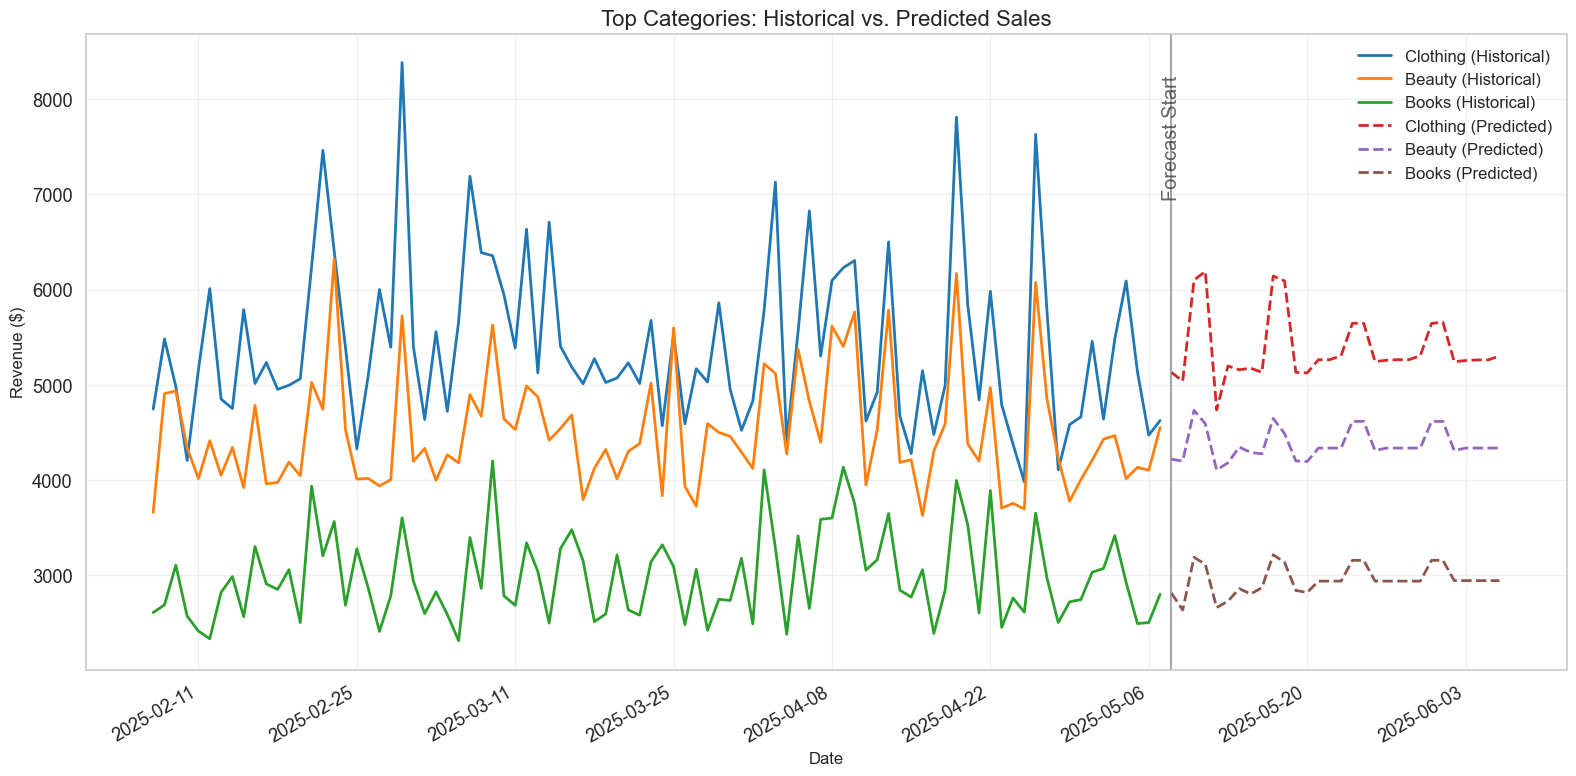

In [6]:
# Identify top categories by average sales
top_categories = full_data[target_categories].mean().sort_values(ascending=False).head(3).index.tolist()
print(f"Top 3 categories by average sales: {', '.join(top_categories)}")

# Plot historical and predicted data for top categories
plt.figure(figsize=(16, 8))

# Plot historical data (last 90 days)
historical_days = 90
for cat in top_categories:
    plt.plot(
        full_data.index[-historical_days:], 
        full_data[cat].tail(historical_days), 
        label=f'{cat} (Historical)', 
        linewidth=2
    )

# Plot predicted data
for cat in top_categories:
    plt.plot(
        predicted_df.index, 
        predicted_df[cat], 
        label=f'{cat} (Predicted)', 
        linewidth=2, 
        linestyle='--'
    )

# Add vertical line to separate historical and predicted data
plt.axvline(x=forecast_start_date, color='gray', linestyle='-', alpha=0.7)
plt.text(forecast_start_date, plt.ylim()[1]*0.95, 'Forecast Start', 
         horizontalalignment='center', verticalalignment='top', rotation=90, alpha=0.7)

# Format the plot
plt.title('Top Categories: Historical vs. Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### 5.2 Total Sales Forecast

Now let's look at the total sales across all categories.


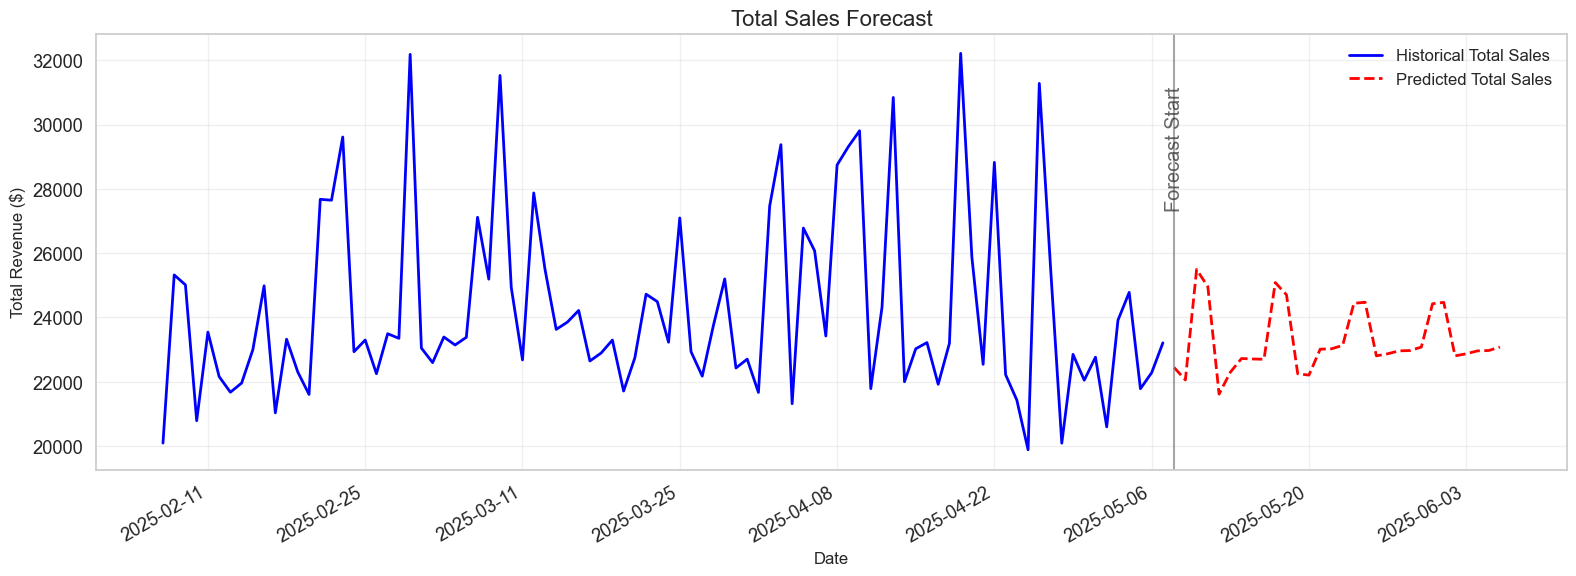

In [7]:
# Calculate total historical sales
full_data['total_sales'] = full_data[target_categories].sum(axis=1)

# Plot total sales
plt.figure(figsize=(16, 6))

# Plot historical total sales (last 90 days)
plt.plot(
    full_data.index[-historical_days:], 
    full_data['total_sales'].tail(historical_days), 
    label='Historical Total Sales', 
    color='blue', 
    linewidth=2
)

# Plot predicted total sales
plt.plot(
    predicted_df.index, 
    predicted_df['total_sales'], 
    label='Predicted Total Sales', 
    color='red', 
    linewidth=2, 
    linestyle='--'
)

# Add vertical line to separate historical and predicted data
plt.axvline(x=forecast_start_date, color='gray', linestyle='-', alpha=0.7)
plt.text(forecast_start_date, plt.ylim()[1]*0.95, 'Forecast Start', 
         horizontalalignment='center', verticalalignment='top', rotation=90, alpha=0.7)

# Format the plot
plt.title('Total Sales Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

## 6. Store Predictions in Database

Now that we've generated and analyzed our predictions, let's store them in the database for future use.


In [8]:
# Prepare predictions for database storage
db_predictions = predicted_df.reset_index()
db_predictions = db_predictions.rename(columns={'index': 'date'})

# Add required columns for the database
for col in ['year', 'month', 'day_of_week', 'is_weekend', 'week_of_year', 'quarter', 
            'is_month_end', 'is_month_start', 'is_november']:
    if col not in db_predictions.columns:
        if col == 'year':
            db_predictions[col] = db_predictions['date'].dt.year
        elif col == 'month':
            db_predictions[col] = db_predictions['date'].dt.month
        elif col == 'day_of_week':
            db_predictions[col] = db_predictions['date'].dt.dayofweek
        elif col == 'is_weekend':
            db_predictions[col] = (db_predictions['day_of_week'] >= 5).astype(int)
        elif col == 'week_of_year':
            db_predictions[col] = db_predictions['date'].dt.isocalendar().week
        elif col == 'quarter':
            db_predictions[col] = db_predictions['date'].dt.quarter
        elif col == 'is_month_end':
            db_predictions[col] = db_predictions['date'].dt.is_month_end.astype(int)
        elif col == 'is_month_start':
            db_predictions[col] = db_predictions['date'].dt.is_month_start.astype(int)
        elif col == 'is_november':
            db_predictions[col] = (db_predictions['date'].dt.month == 11).astype(int)

# Add lag columns required by the database schema
for category in target_categories:
    for lag in [1, 7, 14]:
        lag_col = f"{category}_lag_{lag}"
        if lag_col not in db_predictions.columns:
            db_predictions[lag_col] = 0  # Initialize with zeros

# Store predictions in database
# Uncomment the following lines to actually store the predictions
#rows_inserted = store_predictions(db_predictions, force=True)
#print(f"Successfully stored {rows_inserted} predictions in the database")

# For demonstration purposes only
#print(f"Prepared {len(db_predictions)} predictions for database storage")
#print("Database storage code is commented out. Uncomment to actually store predictions.")